In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import tqdm

import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/vae_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/CelebA_Vae/0818_212439/checkpoint_4499.ckpt")

Missing logger folder: saved/log/CelebA_SigmaVae/0821_225435/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/CelebA_SigmaVae/0821_225435 exists and is not empty.
Restoring states from the checkpoint path at saved/models/CelebA_Vae/0818_212439/checkpoint_4499.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:360: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Vae/0818_212439' to '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_SigmaVae/0821_225435', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | importance | ConvolutionalVae | 790 K  | train
1 | elbo       | 

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=4500` reached.


In [7]:
model.eval()
model.cuda()

LightningSvi(
  (importance): ConvolutionalVae(
    (decoder): ConvolutionalDecoder(
      (linear): Sequential(
        (0): Linear(in_features=40, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): SiLU()
      )
      (convs): Sequential(
        (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): SiLU()
        (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): SiLU()
        (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (8): SiLU()
        (9): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)

In [9]:
x_hats = model.forward(xs, B=len(xs), P=model.num_particles).mean(dim=0)

/usr/local/lib/python3.10/dist-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'X'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


In [10]:
import matplotlib.pyplot as plt

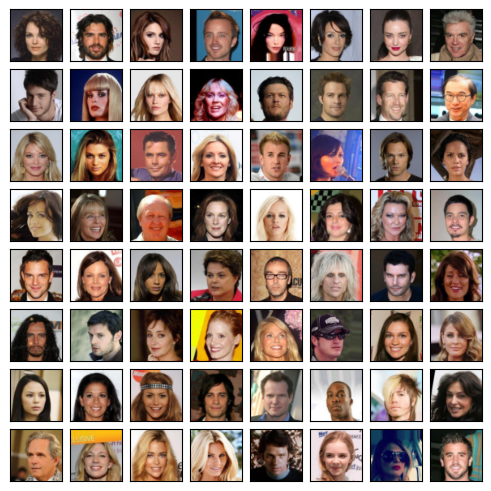

In [11]:
orgs = data.reverse_transform(xs.detach().cpu()).transpose(-3, -1)
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")

for row in range(8):
    for col in range(8):
        axes[row, col].imshow(orgs[row * 8 + col])
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_orgs.pdf", bbox_inches="tight")
plt.show()

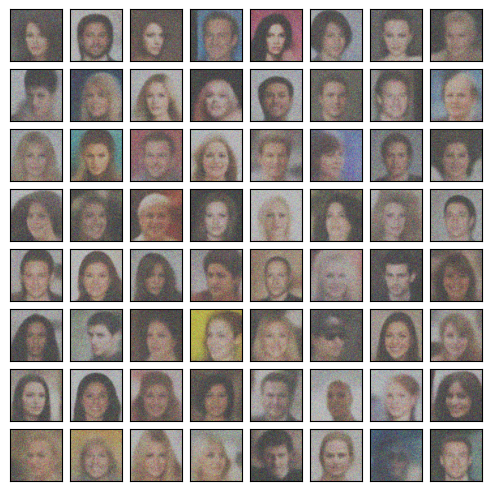

In [12]:
estimates = data.reverse_transform(x_hats.detach().cpu()).transpose(-3, -1).clamp(0, 1)
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")

for row in range(8):
    for col in range(8):
        axes[row, col].imshow(estimates[row * 8 + col])
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [13]:
del x_hats

In [14]:
posterior = {"z": model.importance.encoder(xs).to_event(1).rsample((model.num_particles,))}
x_hats = model.importance.predict(xs, B=xs.shape[0], P=model.num_particles, **posterior)
# x_hats = torch.flatten(x_hats, 0, 1)

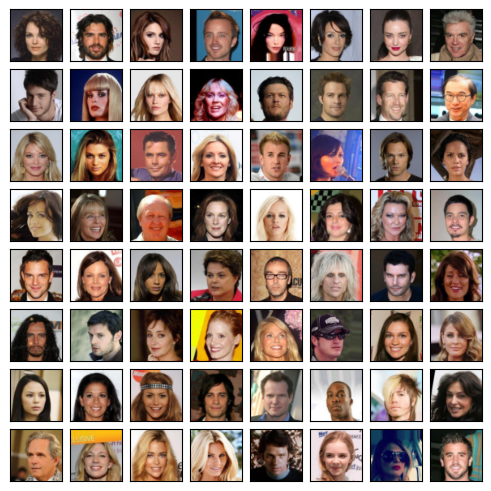

In [15]:
estimates = data.reverse_transform(x_hats.squeeze().detach().cpu()).transpose(-3, -1).clamp(0, 1)
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")

for row in range(8):
    for col in range(8):
        axes[row, col].imshow(estimates[row * 8 + col])
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_predictive.pdf", bbox_inches="tight")
plt.show()

In [16]:
del x_hats

In [17]:
x_hats = model.forward(xs, B=64, mode="prior", P=model.num_particles)
x_hats = x_hats.flatten(0, 1)

ValueError: at plates "data_0" and "importance_0", collide at dim=-1

Try moving the dim of one plate to the left, e.g. dim=-2

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")
estimates = data.reverse_transform(x_hats.squeeze().detach().cpu()).transpose(-3, -1).clamp(0, 1)

for row in range(8):
    for col in range(8):
        axes[row, col].imshow(estimates[row * 8 + col])
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_priors.pdf", bbox_inches="tight")
plt.show()

In [18]:
del x_hats

NameError: name 'x_hats' is not defined

In [19]:
model.importance.decoder.scale

tensor(1., device='cuda:7')

In [20]:
fids = []
metrics = collections.defaultdict(lambda: [])
data.setup("test")

for f in range(10):
    for b, batch in enumerate(tqdm.tqdm(data.test_dataloader(), desc='Test set FIDs')):
        ms = model.test_step(batch, b)
        for k, v in ms.items():
            metrics[k].append(v)
    fids.append(model.metrics['fid'].compute())
    model.metrics['fid'].reset()
    model.graph.gmm = None

fids = torch.stack(fids, dim=0)
fids.mean(), fids.std()

Files already downloaded and verified


Test set FIDs:   0%|                                                                                                                                                                    | 0/312 [00:00<?, ?it/s]


ValueError: at plates "data_0" and "importance_0", collide at dim=-1

Try moving the dim of one plate to the left, e.g. dim=-2
Trace Shapes:     
 Param Sites:     
Sample Sites:     
  data_0 dist    |
        value 64 |

In [ ]:
for k, v in metrics.items():
    metrics[k] = torch.tensor(v)

In [ ]:
{m: v.mean(dim=-1) for m, v in metrics.items()}

In [ ]:
{m: v.std(dim=-1) for m, v in metrics.items()}